# 

In [3]:
import pandas as pd
from etna.models import NaiveModel, AutoARIMAModel, ProphetModel, CatBoostMultiSegmentModel
from etna.datasets import TSDataset
from etna.pipeline import Pipeline
from etna.metrics import SMAPE, MAE, MAPE
from etna.analysis import stl_plot
from etna.transforms import (STLTransform, LagTransform, SegmentEncoderTransform,
                             DateFlagsTransform, MeanTransform)
from copy import deepcopy
from etna.transforms import (TimeSeriesImputerTransform,
                             DensityOutliersTransform,
                             MedianOutliersTransform)
from etna.analysis.outliers import (get_anomalies_density,
                                    get_anomalies_median,
                                    get_anomalies_prediction_interval)
from etna.analysis import (plot_anomalies, plot_anomalies_interactive,
                           plot_backtest, plot_forecast)
from etna.models import ProphetModel
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
from etna.datasets import TSDataset

c:\Works\ML\project\venv\lib\site-packages\etna\settings.py:37: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
c:\Works\ML\project\venv\lib\site-packages\etna\settings.py:45: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
c:\Works\ML\project\venv\lib\site-packages\etna\settings.py:62: UserWarning: etna[classification] is not available, to install it, run `pip install etna[classification]`
  warnings.warn("etna[classification] is not available, to install it, run `pip install etna[classification]`")
c:\Works\ML\project\venv\lib\site-packages\etna\settings.py:71: UserWarning: etna[auto] is not available, to install it, run `pip install etna[auto]`
  warnings.warn("etna[auto] is not available, to install it, run `pip install etna[auto]

In [5]:
HORIZON = 30
EXTRACTION_SETTINGS = MinimalFCParameters()

def _read_csv(file_name):
    df = pd.read_csv(file_name)
    return df

def _set_index(df):
    df['date'] = pd.to_datetime(df['date'])
    df.rename(columns={'date': 'timestamp'}, inplace=True)
    df.set_index('timestamp', inplace=True)
    return df

def _drops(df):
    df = df.drop("RD", axis=1)
    return df

def _reindex(df):
    full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
    df_filled = df.reindex(full_index).fillna(method='ffill')
    return df_filled

def _reset_index(df):
    df = df.reset_index().rename(columns={'index': 'timestamp'})
    return df

def _correct_df(df):
    feature_columns = df.columns.difference(['timestamp', 
                                             'WFC_Close', 
                                             'JPM_Close', 
                                             'Citi_Close', 
                                             'BAC_Close']).tolist()
    target_columns = ['WFC_Close', 'JPM_Close', 'Citi_Close', 'BAC_Close']

    df_corrected = pd.melt(df, id_vars=['timestamp'] + feature_columns, 
                           value_vars=target_columns, var_name='segment', 
                           value_name='target')
    return df_corrected

def _create_ts(df):
    ts_dataset = TSDataset.to_dataset(df)
    ts = TSDataset(ts_dataset, freq='B')

    return ts

def _get_corrected_ts(data, target, dropped):
    feature_columns = data.columns.difference(dropped).tolist()
    target_columns = target
    
    df_corrected = pd.melt(data, id_vars=['timestamp'] + feature_columns,
                               value_vars=target_columns,
                               var_name='segment', value_name='target')

    return _create_ts(df_corrected)

def _to_pandas(ts):
    return ts.to_pandas(flatten=True)


def _extract_features(df):
    return extract_features(
        df,
        column_id='segment',
        column_sort='timestamp',
        default_fc_parameters=EXTRACTION_SETTINGS
    )

def _get_new_features_ts(df, target, dropped):
    ts = _get_corrected_ts(df, target, dropped)
    df = _to_pandas(ts)
    features = _extract_features(df)

    for feature_name in features.columns:
        df[feature_name] = features[feature_name].values[0]

    return _create_ts(df)
    

In [6]:
def create_featured_ts(name):
    df = _read_csv(name)
    df = _set_index(df)
    df = _drops(df)
    df = _reindex(df)
    df = _reset_index(df)
    df = _correct_df(df)
    features = _extract_features(df)
    for feature_name in features.columns:
        df[feature_name] = features[feature_name].values[0]
    ts = _create_ts(df)
    return ts

In [7]:
def create_ts(name):
    df = _read_csv(name)
    df = _set_index(df)
    df = _drops(df)
    df = _reindex(df)
    df = _reset_index(df)
    df = _correct_df(df)
    ts = _create_ts(df)
    return ts

In [63]:
def save_to_csv(forecast_ts):
    forecast_ts[:, :, "target"].round(3).to_csv("last_forecast.csv")
    res_df = pd.read_csv("last_forecast.csv")
    res_df.rename(columns={'segment': 'date'}, inplace=True)
    res_df.set_index('date', inplace=True)
    res_df = res_df.iloc[2:]
    res_df.to_csv("last_forecast.csv")

    return res_df


In [64]:
save_to_csv(forecast)

,BAC_Close,Citi_Close,JPM_Close,WFC_Close
date,,,,
2023-11-01,25.647,39.2,140.249,39.006
2023-11-02,25.538,38.778,140.115,38.872
2023-11-03,25.477,38.499,139.783,38.26
2023-11-06,25.395,38.425,140.431,38.434
2023-11-07,24.661,37.607,137.832,37.448
2023-11-08,24.561,37.669,138.009,37.465
2023-11-09,24.663,37.834,138.378,37.543
2023-11-10,24.503,37.674,136.267,37.543
2023-11-13,24.147,37.356,136.075,36.639


In [8]:
def catboost(ts):
    train_ts, test_ts = ts.train_test_split(test_size=HORIZON)
    
    catboost_model = CatBoostMultiSegmentModel(iterations = 750, depth = 5, learning_rate = 0.001)
    
    stl = STLTransform(in_column="target", period=30, model="arima")
    anomaly = DensityOutliersTransform(in_column="target", window_size=5, distance_coef=2.5)
    seg = SegmentEncoderTransform()
    lags = LagTransform(in_column="target", lags=list(range(HORIZON, 365)), out_column="lag")

    transforms = [stl, seg, lags, anomaly]  
    pipeline = Pipeline(model=catboost_model, transforms=transforms, horizon=HORIZON)

    metrics_df, forecast_df, fold_info_df = pipeline.backtest(
        ts=ts, metrics=[SMAPE(), MAE(), MAPE()], n_jobs=10
    )
    print(metrics_df.groupby(['segment']).mean())
    
    pipeline.fit(train_ts)
    forecast_ts = pipeline.forecast()
    plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=100)
    pipeline.save("last_pipeline")
    return forecast_ts

In [45]:
def catboost_train(ts):
    catboost_model = CatBoostMultiSegmentModel(iterations = 750, depth = 5, learning_rate = 0.001)
    
    stl = STLTransform(in_column="target", period=30, model="arima")
    anomaly = DensityOutliersTransform(in_column="target", window_size=5, distance_coef=2.5)
    seg = SegmentEncoderTransform()
    lags = LagTransform(in_column="target", lags=list(range(HORIZON, 365)), out_column="lag")

    transforms = [stl, seg, lags, anomaly]  
    pipeline = Pipeline(model=catboost_model, transforms=transforms, horizon=HORIZON)

    metrics_df, forecast_df, fold_info_df = pipeline.backtest(
        ts=ts, metrics=[SMAPE(), MAE(), MAPE()], n_jobs=10
    )
    print(metrics_df.groupby(['segment']).mean())
    
    pipeline.fit(ts)
    forecast_ts = pipeline.forecast()
    save_to_csv(forecast_ts)
    return forecast_ts

In [6]:
def naive(ts):
    train_ts, test_ts = ts.train_test_split(test_size=HORIZON)
    
    model = NaiveModel(lag=30)

    # Define a pipeline
    pipeline = Pipeline(model=model, horizon=HORIZON)

    metrics_df, forecast_df, fold_info_df = pipeline.backtest(
        ts=ts, metrics=[SMAPE(), MAE(), MAPE()], n_jobs=10
    )
    print(metrics_df.groupby(['segment']).mean())
    
    pipeline.fit(train_ts)
    forecast_ts = pipeline.forecast()
    plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=60)

In [7]:
def arima(ts):
    train_ts, test_ts = ts.train_test_split(test_size=HORIZON)
    
    autoarima_model = AutoARIMAModel(lag=30)
    print(autoarima_model)
    pipeline = Pipeline(model=autoarima_model, horizon=HORIZON)

    metrics_df, forecast_df, fold_info_df = pipeline.backtest(
        ts=ts, metrics=[SMAPE(), MAE(), MAPE()], n_jobs=10
    )
    print(metrics_df.groupby(['segment']).mean())
    
    pipeline.fit(train_ts)
    forecast_ts = pipeline.forecast()
    plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=30)

In [8]:
def prophet(ts):
    train_ts, test_ts = ts.train_test_split(test_size=HORIZON)
    
    prophet_model = ProphetModel()
    pipeline = Pipeline(model=prophet_model, horizon=HORIZON)

    metrics_df, forecast_df, fold_info_df = pipeline.backtest(
        ts=ts, metrics=[SMAPE(), MAE(), MAPE()], n_jobs=10
    )
    print(metrics_df.groupby(['segment']).mean())
    
    pipeline.fit(train_ts)
    forecast_ts = pipeline.forecast()
    plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=30)

In [46]:
ts = create_ts('union.csv')

In [47]:
ts

segment     BAC_Close                                                 \
feature    BAC_Volume  CPI Citi_Volume Consumer Confidence Index USD   
timestamp                                                              
2020-01-02     3764.0  2.3      1273.0               130.7     96.85   
2020-01-03     5076.0  2.3      1266.0               130.7     96.84   
2020-01-06     4223.0  2.3      1007.0               130.7     96.67   
2020-01-07     3435.0  2.3      1049.0               130.7     97.00   
2020-01-08     4534.0  2.3      1129.0               130.7     97.30   
...               ...  ...         ...                 ...       ...   
2023-10-25     4516.0  6.5      1508.0               108.3    106.53   
2023-10-26     6032.0  6.5      2492.0               108.3    106.60   
2023-10-27     6471.0  6.5      2065.0               108.3    106.56   
2023-10-30     4122.0  6.5      2065.0               108.3    106.12   
2023-10-31     4957.0  6.5      1627.0               108.3    106.66   

segment                                                                        \
feature    Industry PMI JPM_Volume Nominal GDP Index Nominal_GDP_deviation(%)   
timestamp                                                                       
2020-01-02         51.7     1081.0      27832.404974                    23.44   
2020-01-03         51.7     1039.0      27832.404974                    23.44   
2020-01-06         51.7     1027.0      27832.404974                    23.44   
2020-01-07         51.7     1058.0      27832.404974                    23.44   
2020-01-08         51.7      970.0      27832.404974                    23.44   
...                 ...        ...               ...                      ...   
2023-10-25         50.0      732.0      21899.725179                     6.18   
2023-10-26         50.0      900.0      21899.725179                     6.18   
2023-10-27         50.0     1743.0      21899.725179                     6.18   
2023-10-30         50.0      882.0      21899.725179                     6.18   
2023-10-31         50.0      902.0      21899.725179                     6.18   

segment                    ...  WFC_Close                    \
feature    Real GDP Index  ... JPM_Volume Nominal GDP Index   
timestamp                  ...                                
2020-01-02   22546.406263  ...     1081.0      27832.404974   
2020-01-03   22546.406263  ...     1039.0      27832.404974   
2020-01-06   22546.406263  ...     1027.0      27832.404974   
2020-01-07   22546.406263  ...     1058.0      27832.404974   
2020-01-08   22546.406263  ...      970.0      27832.404974   
...                   ...  ...        ...               ...   
2023-10-25   20626.059553  ...      732.0      21899.725179   
2023-10-26   20626.059553  ...      900.0      21899.725179   
2023-10-27   20626.059553  ...     1743.0      21899.725179   
2023-10-30   20626.059553  ...      882.0      21899.725179   
2023-10-31   20626.059553  ...      902.0      21899.725179   

segment                                                                  \
feature    Nominal_GDP_deviation(%) Real GDP Index  S&P_500 Service PMI   
timestamp                                                                 
2020-01-02                    23.44   22546.406263  3257.85        53.2   
2020-01-03                    23.44   22546.406263  3234.85        53.2   
2020-01-06                    23.44   22546.406263  3246.28        53.2   
2020-01-07                    23.44   22546.406263  3237.18        53.2   
2020-01-08                    23.44   22546.406263  3253.05        53.2   
...                             ...            ...      ...         ...   
2023-10-25                     6.18   20626.059553  4186.77        50.9   
2023-10-26                     6.18   20626.059553  4137.23        50.9   
2023-10-27                     6.18   20626.059553  4117.37        50.9   
2023-10-30                     6.18   20626.059553  4166.82        50.9  

In [48]:
forecast = catboost_train(ts)

[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   26.0s
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:   29.4s remaining:   44.2s
[Parallel(n_jobs=10)]: Done   3 out of   5 | elapsed:   33.2s remaining:   22.1s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   39.1s finished
[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    3.9s remaining:    5.8s
[Parallel(n_jobs=10)]: Done   3 out of   5 | elapsed:    5.7s remaining:    3.7s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    9.4s finished
[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Pa

               SMAPE       MAE      MAPE  fold_number
segment                                              
BAC_Close   5.984029  1.746753  6.053127          2.0
Citi_Close  4.873432  2.176014  5.001602          2.0
JPM_Close   4.950748  7.157593  4.928418          2.0
WFC_Close   5.999241  2.513498  6.020451          2.0


c:\Works\ML\project\venv\lib\site-packages\etna\transforms\decomposition\stl.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[self.in_column] -= season_trend
c:\Works\ML\project\venv\lib\site-packages\etna\transforms\decomposition\stl.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[self.in_column] -= season_trend
c:\Works\ML\project\venv\lib\site-packages\etna\transforms\decomposition\stl.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [53]:
ttt = save_to_csv(forecast)

print(ttt.head())

segment    BAC_Close Citi_Close JPM_Close WFC_Close
feature       target     target    target    target
timestamp                                          
2023-11-03    25.477     38.499   139.783    38.260
2023-11-06    25.395     38.425   140.431    38.434
2023-11-07    24.661     37.607   137.832    37.448
2023-11-08    24.561     37.669   138.009    37.465
2023-11-09    24.663     37.834   138.378    37.543


AttributeError: 'NoneType' object has no attribute 'head'

In [34]:
forecast[:, :, "target"].round(3).to_csv("test.csv")

In [35]:
test = pd.read_csv("test.csv")

test


,segment,BAC_Close,Citi_Close,JPM_Close,WFC_Close
0,feature,target,target,target,target
1,timestamp,NaN,NaN,NaN,NaN
2,2023-11-01,25.647,39.2,140.249,39.006
3,2023-11-02,25.538,38.778,140.115,38.872
4,2023-11-03,25.477,38.499,139.783,38.26
5,2023-11-06,25.395,38.425,140.431,38.434
6,2023-11-07,24.661,37.607,137.832,37.448
7,2023-11-08,24.561,37.669,138.009,37.465
8,2023-11-09,24.663,37.834,138.378,37.543
9,2023-11-10,24.503,37.674,136.267,37.543


[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   25.9s
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:   29.7s remaining:   44.6s
[Parallel(n_jobs=10)]: Done   3 out of   5 | elapsed:   33.5s remaining:   22.3s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   39.4s finished
[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.2s
[Parallel(n_jobs=10)]: Done   3 out of   5 | elapsed:    6.0s remaining:    4.0s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    9.9s finished
[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Pa

               SMAPE       MAE      MAPE  fold_number
segment                                              
BAC_Close   5.984029  1.746753  6.053127          2.0
Citi_Close  4.873432  2.176014  5.001602          2.0
JPM_Close   4.950748  7.157593  4.928418          2.0
WFC_Close   5.999241  2.513498  6.020451          2.0


c:\Works\ML\project\venv\lib\site-packages\etna\transforms\decomposition\stl.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[self.in_column] -= season_trend
c:\Works\ML\project\venv\lib\site-packages\etna\transforms\decomposition\stl.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[self.in_column] -= season_trend
c:\Works\ML\project\venv\lib\site-packages\etna\transforms\decomposition\stl.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

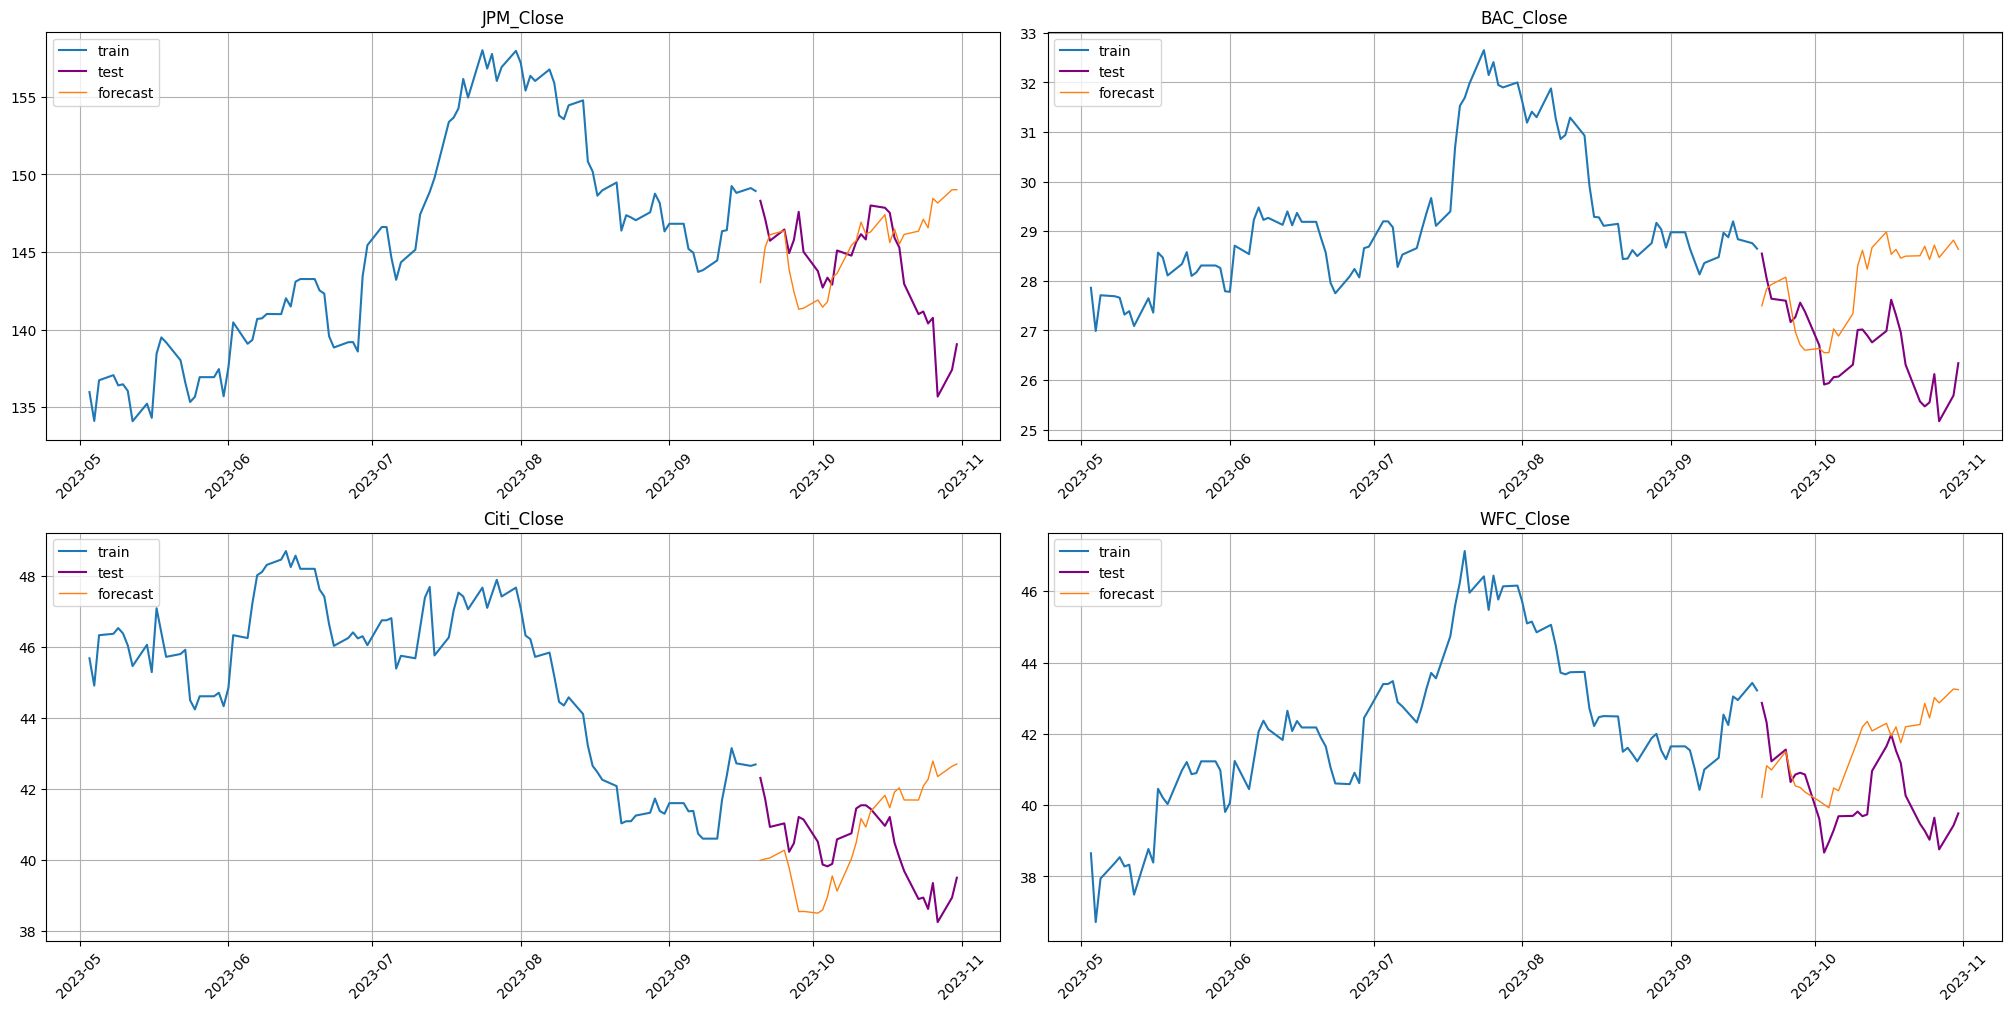

In [14]:
forecast = catboost(ts)

[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
C:\Works\ML\project\venv\lib\site-packages\prophet\serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
C:\Works\ML\project\venv\lib\site-packages\prophet\serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute

               SMAPE       MAE      MAPE  fold_number
segment                                              
BAC_Close   7.789928  2.211883  7.646612          2.0
Citi_Close  6.413228  2.944044  6.636153          2.0
JPM_Close   6.301839  9.299269  6.410339          2.0
WFC_Close   6.826897  2.797316  6.633459          2.0


00:42:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Works\ML\project\venv\lib\site-packages\etna\models\prophet.py:108: UserWarning: This model doesn't work with exogenous features unknown in future. Columns ['BAC_Volume', 'CPI', 'Citi_Volume', 'Consumer Confidence', 'Index USD', 'Industry PMI', 'JPM_Volume', 'Nominal GDP Index', 'Nominal_GDP_deviation(%)', 'Real GDP Index', 'S&P_500', 'Service PMI', 'Trade Balance', 'UnEm', 'WFC_Volume'] won't be used.
  warnings.warn(
00:42:24 - cmdstanpy - INFO - Chain [1] start processing
00:42:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Works\ML\project\venv\lib\site-packages\etna\models\prophet.py:108: UserWarning: This model doesn't work with exogenous features unknown in future. Columns ['BAC_Volume', 'CPI', 'Citi_Volume', 'Consumer Confidence', 'Index USD', 'Industry PMI', 'JPM_Volume', 'Nominal GDP Index', 'Nominal_GDP_deviation(%)', 'Real GDP Index', 'S&P_500', 'Service PMI', 'Trade Balance', 'UnEm', 'WFC_Volume'] won't be us

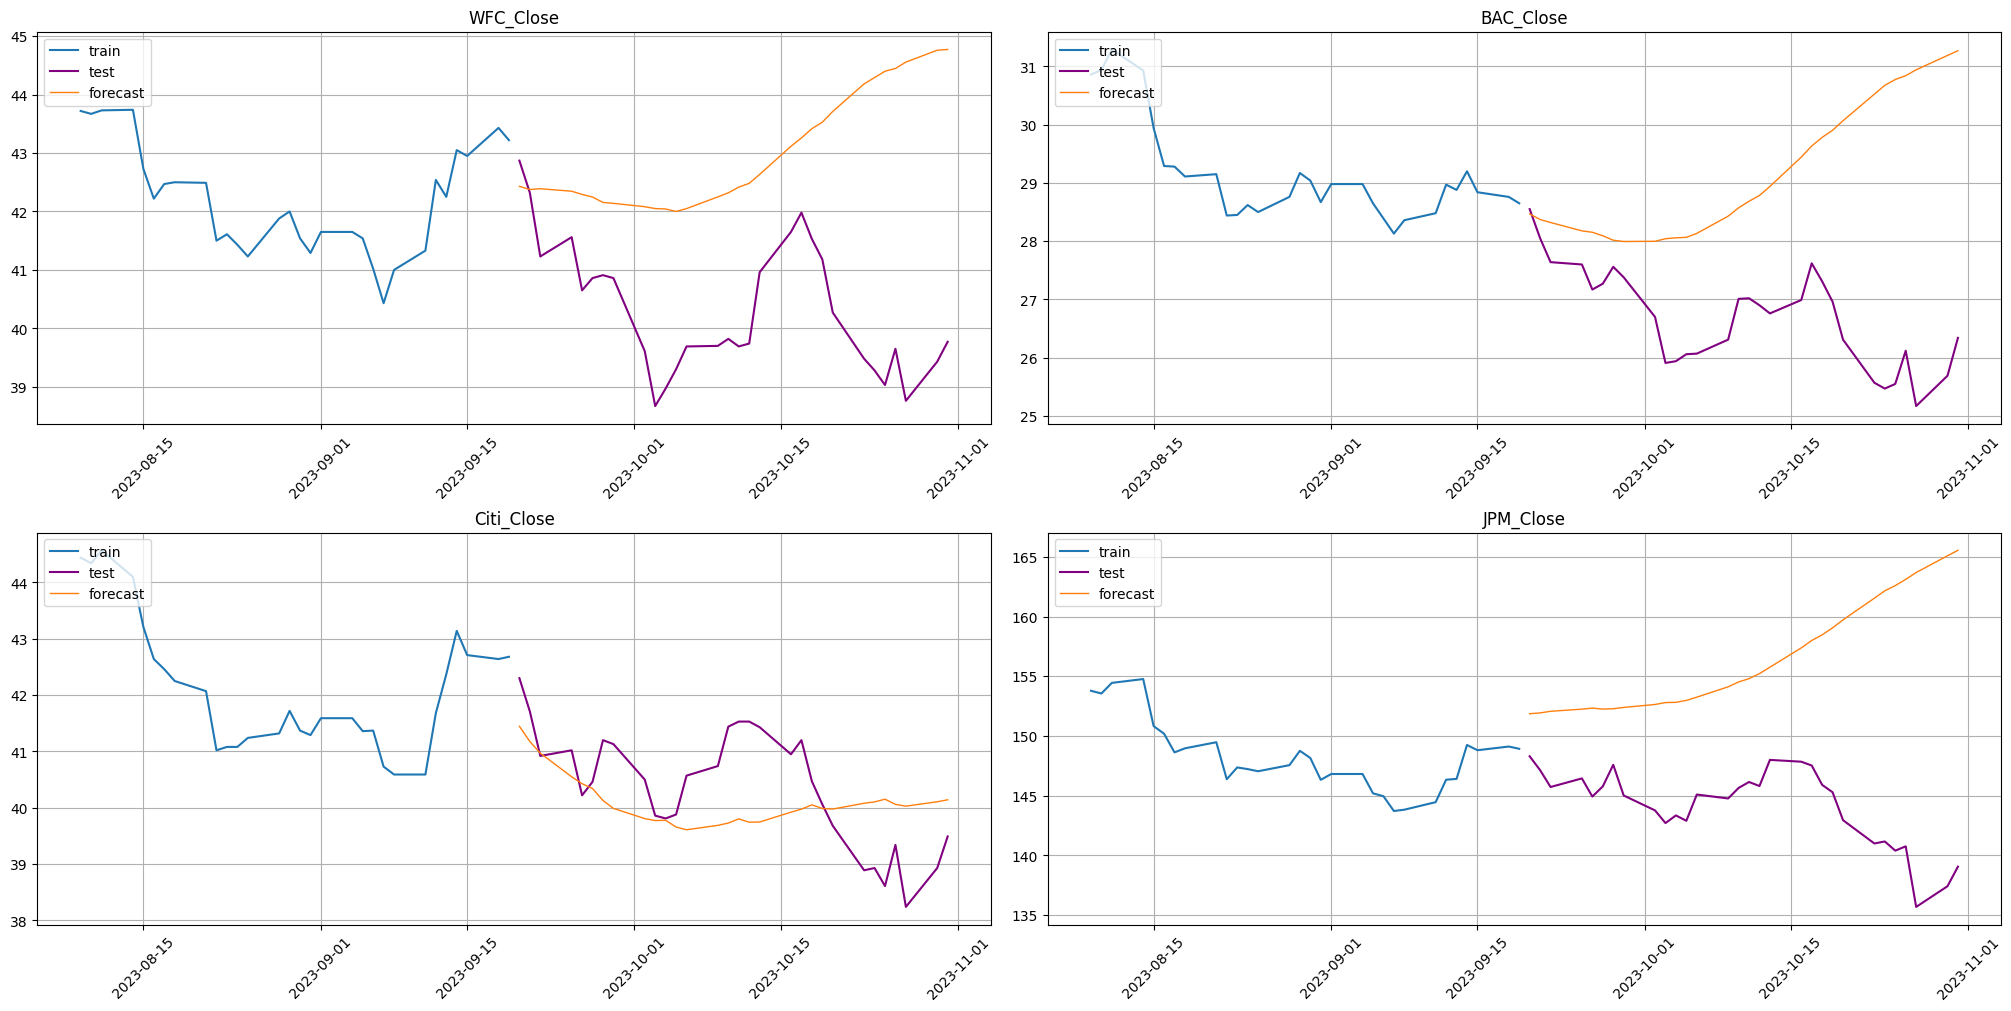

In [ ]:
prophet(ts)

In [ ]:
featured_ts = create_featured_ts('union.csv')

Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 29.29it/s]
C:\Users\garas\AppData\Local\Temp\ipykernel_26308\3653631929.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = features[feature_name].values[0]
C:\Users\garas\AppData\Local\Temp\ipykernel_26308\3653631929.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = features[feature_name].values

In [ ]:
featured_ts

segment     BAC_Close                                                  \
feature    BAC_Volume BAC_Volume__absolute_maximum BAC_Volume__length   
timestamp                                                               
2020-01-02     3764.0                      21840.0              999.0   
2020-01-03     5076.0                      21840.0              999.0   
2020-01-06     4223.0                      21840.0              999.0   
2020-01-07     3435.0                      21840.0              999.0   
2020-01-08     4534.0                      21840.0              999.0   
...               ...                          ...                ...   
2023-10-25     4516.0                      21840.0              999.0   
2023-10-26     6032.0                      21840.0              999.0   
2023-10-27     6471.0                      21840.0              999.0   
2023-10-30     4122.0                      21840.0              999.0   
2023-10-31     4957.0                      21840.0              999.0   

segment                                                             \
feature    BAC_Volume__maximum BAC_Volume__mean BAC_Volume__median   
timestamp                                                            
2020-01-02             21840.0      5307.104104             4706.0   
2020-01-03             21840.0      5307.104104             4706.0   
2020-01-06             21840.0      5307.104104             4706.0   
2020-01-07             21840.0      5307.104104             4706.0   
2020-01-08             21840.0      5307.104104             4706.0   
...                        ...              ...                ...   
2023-10-25             21840.0      5307.104104             4706.0   
2023-10-26             21840.0      5307.104104             4706.0   
2023-10-27             21840.0      5307.104104             4706.0   
2023-10-30             21840.0      5307.104104             4706.0   
2023-10-31             21840.0      5307.104104             4706.0   

segment                                                      \
feature    BAC_Volume__minimum BAC_Volume__root_mean_square   
timestamp                                                     
2020-01-02              1612.0                  5824.515231   
2020-01-03              1612.0                  5824.515231   
2020-01-06              1612.0                  5824.515231   
2020-01-07              1612.0                  5824.515231   
2020-01-08              1612.0                  5824.515231   
...                        ...                          ...   
2023-10-25              1612.0                  5824.515231   
2023-10-26              1612.0                  5824.515231   
2023-10-27              1612.0                  5824.515231   
2023-10-30              1612.0                  5824.515231   
2023-10-31              1612.0                  5824.515231   

segment                                                           ...  \
feature    BAC_Volume__standard_deviation BAC_Volume__sum_values  ...   
timestamp                                                         ...   
2020-01-02                    2399.921604              5301797.0  ...   
2020-01-03                    2399.921604              5301797.0  ...   
2020-01-06                    2399.921604              5301797.0  ...   
2020-01-07                    2399.921604              5301797.0  ...   
2020-01-08                    2399.921604              5301797.0  ...   
...                                   ...                    ...  ...   
2023-10-25                    2399.921604              5301797.0  ...   
2023-10-26                    2399.921604              5301797.0  ...   
2023-10-27                    2399.921604              5301797.0  ...   
2023-10-30                    2399.921604              5301797.0  ...   
2023-10-31                    2399.921604              5301797.0  ...   

segment                   WFC_Close                                 \
feature    target__a

[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   26.1s
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:   30.6s remaining:   45.9s
[Parallel(n_jobs=10)]: Done   3 out of   5 | elapsed:   33.9s remaining:   22.5s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   38.9s finished
[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    4.2s remaining:    6.3s
[Parallel(n_jobs=10)]: Done   3 out of   5 | elapsed:    6.0s remaining:    4.0s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.3s
[Pa

               SMAPE       MAE      MAPE  fold_number
segment                                              
BAC_Close   5.984029  1.746753  6.053127          2.0
Citi_Close  4.873432  2.176014  5.001602          2.0
JPM_Close   4.950748  7.157593  4.928418          2.0
WFC_Close   5.999241  2.513498  6.020451          2.0


C:\Works\ML\project\venv\lib\site-packages\etna\transforms\decomposition\stl.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[self.in_column] -= season_trend
C:\Works\ML\project\venv\lib\site-packages\etna\transforms\decomposition\stl.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[self.in_column] -= season_trend
C:\Works\ML\project\venv\lib\site-packages\etna\transforms\decomposition\stl.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

segment     BAC_Close                                                  \
feature    BAC_Volume BAC_Volume__absolute_maximum BAC_Volume__length   
timestamp                                                               
2023-09-20        NaN                          NaN                NaN   
2023-09-21        NaN                          NaN                NaN   
2023-09-22        NaN                          NaN                NaN   
2023-09-25        NaN                          NaN                NaN   
2023-09-26        NaN                          NaN                NaN   
2023-09-27        NaN                          NaN                NaN   
2023-09-28        NaN                          NaN                NaN   
2023-09-29        NaN                          NaN                NaN   
2023-10-02        NaN                          NaN                NaN   
2023-10-03        NaN                          NaN                NaN   
2023-10-04        NaN                          NaN                NaN   
2023-10-05        NaN                          NaN                NaN   
2023-10-06        NaN                          NaN                NaN   
2023-10-09        NaN                          NaN                NaN   
2023-10-10        NaN                          NaN                NaN   
2023-10-11        NaN                          NaN                NaN   
2023-10-12        NaN                          NaN                NaN   
2023-10-13        NaN                          NaN                NaN   
2023-10-16        NaN                          NaN                NaN   
2023-10-17        NaN                          NaN                NaN   
2023-10-18        NaN                          NaN                NaN   
2023-10-19        NaN                          NaN                NaN   
2023-10-20        NaN                          NaN                NaN   
2023-10-23        NaN                          NaN                NaN   
2023-10-24        NaN                          NaN                NaN   
2023-10-25        NaN                          NaN                NaN   
2023-10-26        NaN                          NaN                NaN   
2023-10-27        NaN                          NaN                NaN   
2023-10-30        NaN                          NaN                NaN   
2023-10-31        NaN                          NaN                NaN   

segment                                                             \
feature    BAC_Volume__maximum BAC_Volume__mean BAC_Volume__median   
timestamp                                                            
2023-09-20                 NaN              NaN                NaN   
2023-09-21                 NaN              NaN                NaN   
2023-09-22                 NaN              NaN                NaN   
2023-09-25                 NaN              NaN                NaN   
2023-09-26                 NaN              NaN                NaN   
2023-09-27                 NaN              NaN                NaN   
2023-09-28                 NaN              NaN                NaN   
2023-09-29                 NaN              NaN                NaN   
2023-10-02                 NaN              NaN                NaN   
2023-10-03                 NaN              NaN                NaN   
2023-10-04                 NaN              NaN                NaN   
2023-10-05                 NaN              NaN                NaN   
2023-10-06                 NaN              NaN                NaN   
2023-10-09                 NaN              NaN                NaN   
2023-10-10                 NaN              NaN                NaN   
2023-10-11                 NaN              NaN                NaN   
2023-10-12                 NaN              NaN                NaN   
2023-10-13                 NaN              NaN                NaN   
2023-10-16                 NaN              NaN                NaN   
2023-10-17                 NaN              NaN   

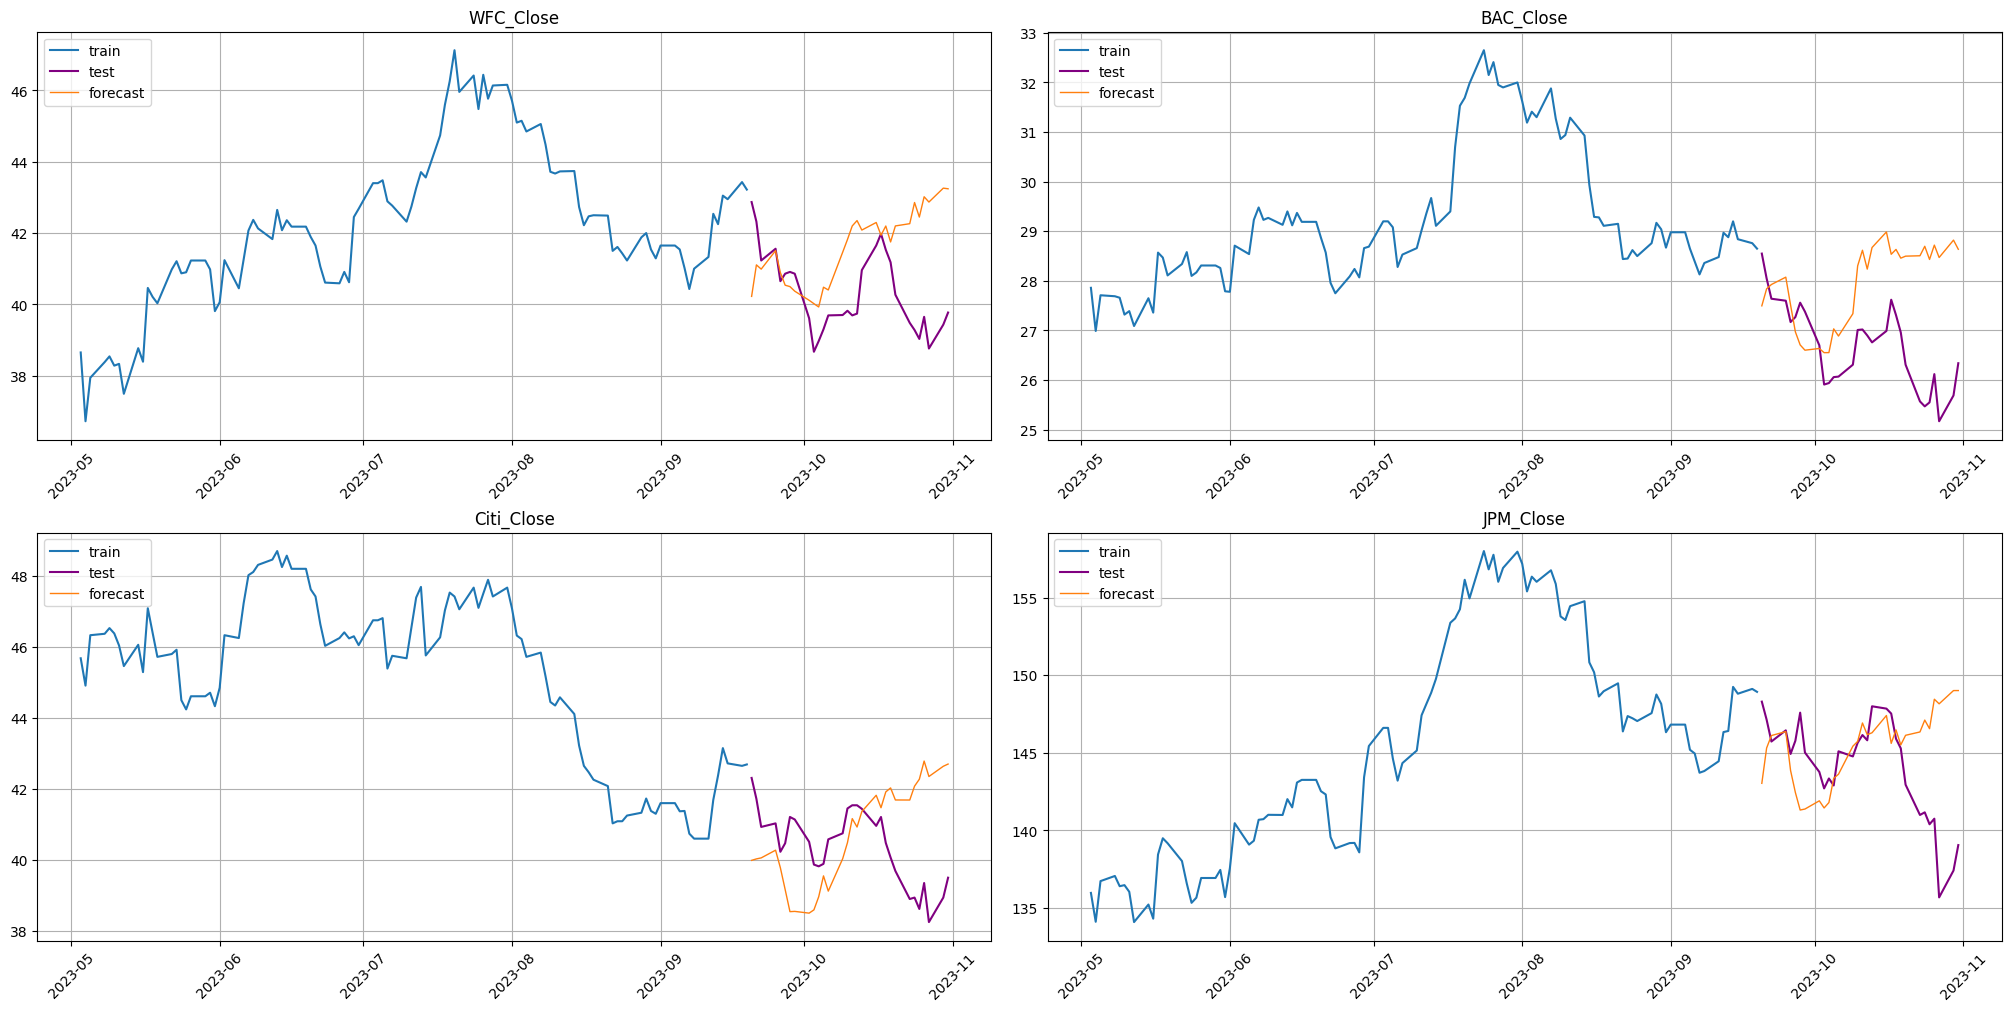

In [ ]:
catboost(featured_ts)

[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.2s
[Parallel(n_jobs=10)]: Done   3 out of   5 | elapsed:    5.2s remaining:    3.4s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.3s
[Parallel(n_jobs=10)]: Done   3 out of   5 | elapsed:    5.2s remaining:    3.5s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Pa

               SMAPE       MAE      MAPE  fold_number
segment                                              
BAC_Close   6.570737  1.935400  6.770824          2.0
Citi_Close  5.141992  2.314933  5.327135          2.0
JPM_Close   5.353490  7.640133  5.294206          2.0
WFC_Close   6.318600  2.653667  6.404027          2.0


C:\Works\ML\project\venv\lib\site-packages\etna\models\seasonal_ma.py:64: UserWarning: This model doesn't work with exogenous features. Columns {'BAC_Volume__minimum', 'JPM_Volume__standard_deviation', 'UnEm', 'Nominal_GDP_deviation(%)__minimum', 'CPI__absolute_maximum', 'Citi_Volume__standard_deviation', 'BAC_Volume__length', 'BAC_Volume__mean', 'S&P_500__sum_values', 'Consumer Confidence__variance', 'Service PMI__length', 'Citi_Volume__length', 'Nominal_GDP_deviation(%)__mean', 'S&P_500__absolute_maximum', 'target__maximum', 'Nominal_GDP_deviation(%)__standard_deviation', 'Nominal GDP Index__mean', 'Nominal_GDP_deviation(%)__sum_values', 'Index USD', 'Nominal_GDP_deviation(%)__median', 'Service PMI__mean', 'BAC_Volume__maximum', 'Citi_Volume__mean', 'WFC_Volume__median', 'Service PMI__root_mean_square', 'UnEm__maximum', 'target__absolute_maximum', 'Real GDP Index__sum_values', 'Service PMI__sum_values', 'UnEm__length', 'BAC_Volume__median', 'Consumer Confidence__minimum', 'Real GDP I

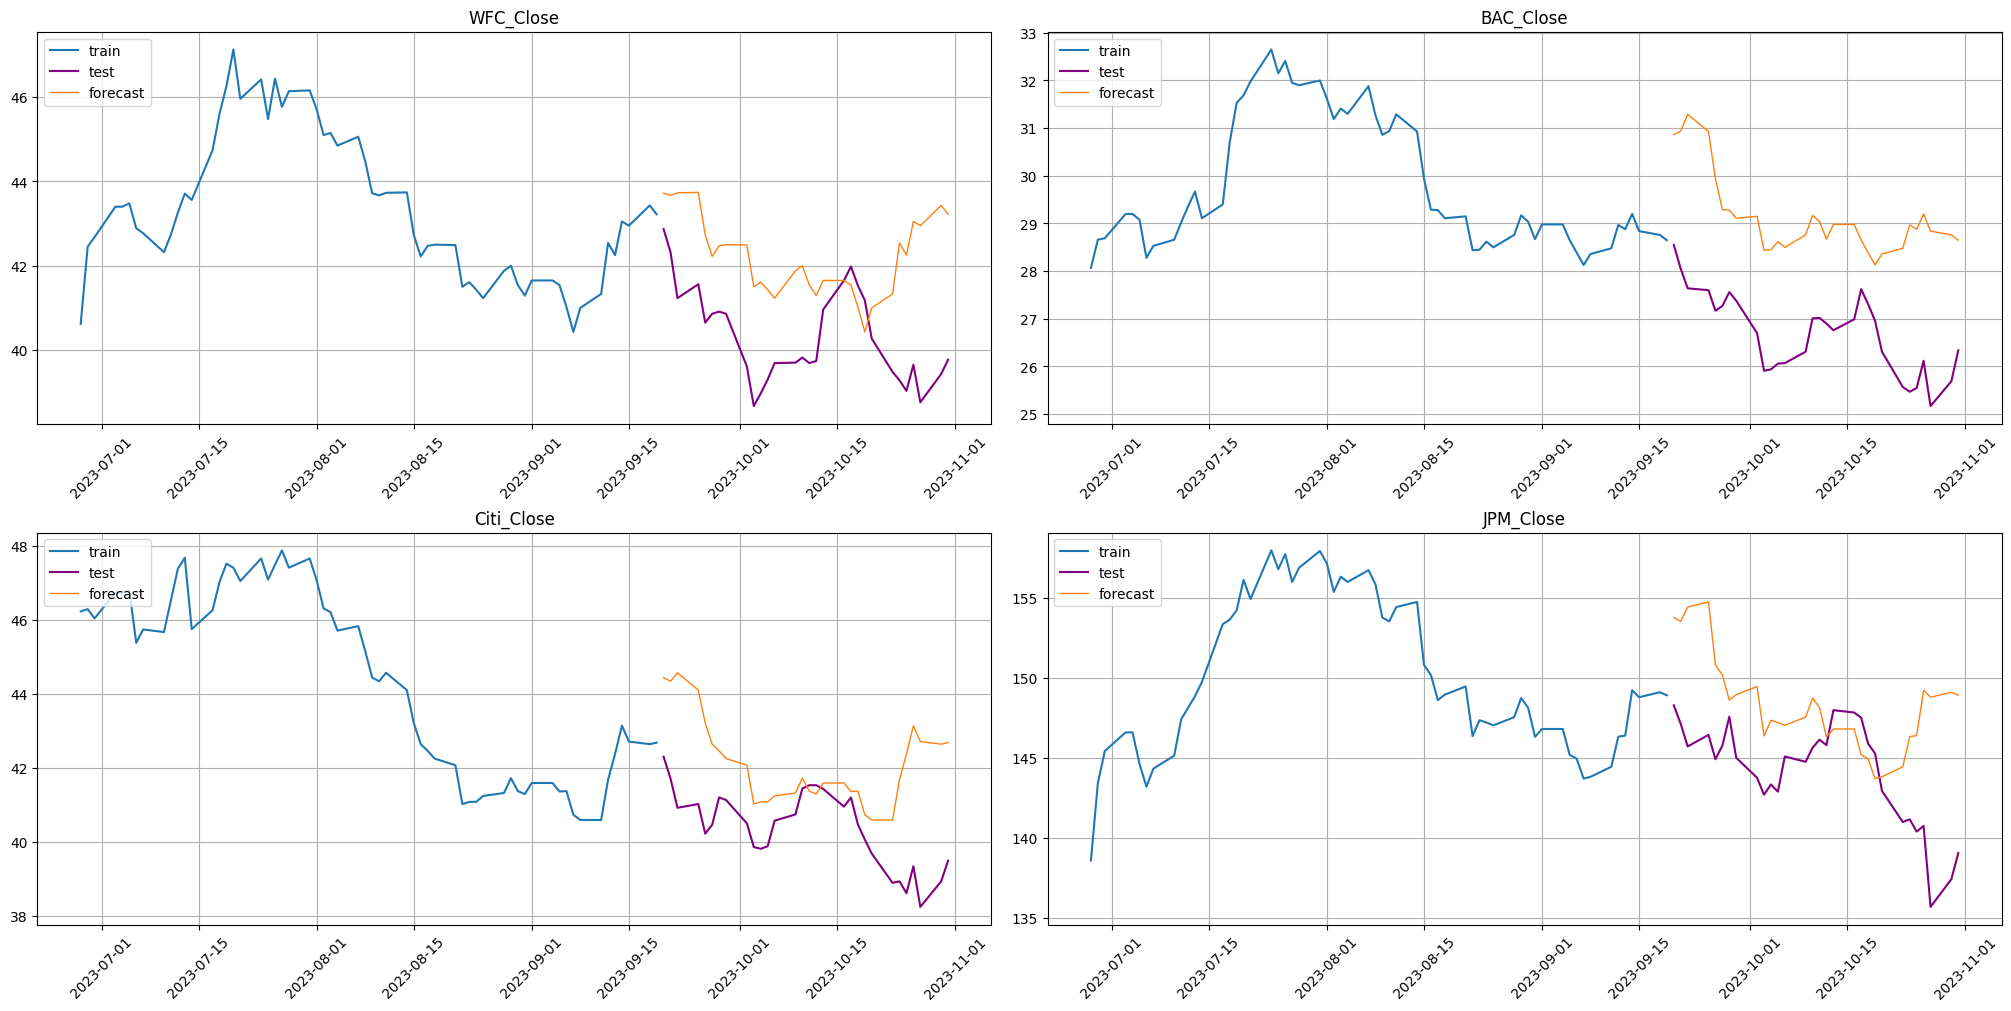

In [ ]:
naive(featured_ts)